In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np

In [2]:
!pip install matplotlib
!pip install numpy

In [19]:
with open('sensitive_analysis_1v30_2v30_3v3.pkl','r') as inputs:
    data = pickle.load(inputs)[:30]
with open('sensitive_analysis_1v34.pkl','r') as inputs:
    data.extend(pickle.load(inputs))
with open('sensitive_analysis_1v36.pkl','r') as inputs:
    data.extend(pickle.load(inputs))
with open('sensitive_analysis_base.pkl','r') as inputsbase:
    data_base = pickle.load(inputsbase)

In [20]:
data

[([0, 0.0, 0.0, 0.0, 19.972, 0.0, 469.238],
  [[2.936590598443125, 4.63, 6.1], [0.6, 0.63, 0.67], [-0.25, -0.5, -1.0]],
  array([ 0.82705012,  0.98510101,  0.83622702,  1.29430298,  1.03839455,
          1.04656337,  0.90847734,  1.11118486,  1.08507569,  1.18038913,
          1.14022033,  1.20497255,  1.18046675,  1.22432107,  0.9130493 ,
          1.0358135 ,  0.98987649,  1.02475183,  0.99111731,  1.03948896,
          1.00006278,  1.04296079,  1.00847832,  1.03902349,  1.0042007 ,
          1.02939827,  0.99740775,  1.06367098,  1.02473331,  1.33646397,
          0.98460694,  0.94789565,  0.92764986,  0.96234804,  0.94067783,
          0.95747591,  0.93482485,  0.97009744,  0.94880193,  0.95689559,
          0.93369415,  0.9695716 ,  0.94845181,  0.96249225,  0.94239323,
          0.98046154,  0.89974711,  0.95461325,  0.93579631,  0.96499892,
          0.94300341,  0.95931604,  0.93684189,  0.96997905,  0.90424308,
          0.96082051,  0.93874342,  0.97876303,  0.91314597,  1.00

In [21]:
def get_price_stat_ave(data,decision_times): #period average for each sample
    mitigation = []
    utility = []
    price = []
    from tree import TreeModel 
    for i in range(len(data)): #load corresponding results
        mitigation.append(data[i][2])
        utility.append(data[i][3])
        price.append(data[i][4])
    
    t = TreeModel(decision_times)
    nodes_index = []
    for i in range(t.num_periods):
        nodes_index.append(t.get_nodes_in_period(i)) #get nodes for slicing
    price_stat_ave = np.zeros((len(data), t.num_periods))
    for i in range(len(data)):
        for j in range(t.num_periods):
            price_stat_ave[i,j] = np.average(data[i][4][nodes_index[j][0]:nodes_index[j][1]+1])
    return price_stat_ave

def get_90_quantile(price_stat_ave):
    list0 = price_stat_ave[:,0]
    list1 = price_stat_ave[:,1]
    list2 = price_stat_ave[:,2]
    list3 = price_stat_ave[:,3]
    list4 = price_stat_ave[:,4]
    list5 = price_stat_ave[:,5]
    list_ = [list0,list1,list2,list3,list4,list5]
    for i in range(len(list_)):
        list_[i]=np.sort(list_[i])[5:95] #take the 90% of the sorted results
    list_min = []
    list_max = []
    for i in list_:
        list_min.append(i[0])
        list_max.append(i[-1])   
    return list_min,list_max #take the lower and upper bounds for the test results

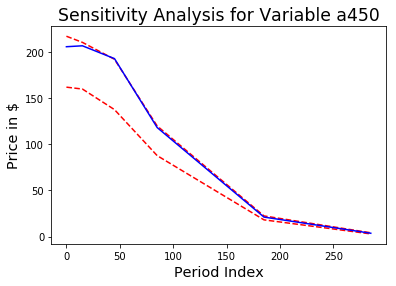

In [24]:
decision_times=[0, 15, 45, 85, 185, 285, 385]
price_stat_ave= get_price_stat_ave(data,decision_times)
price_stat_ave_base =get_price_stat_ave(data_base,decision_times)

list_min,list_max = get_90_quantile(price_stat_ave)
plt.figure()
plt.plot(decision_times[:-1],list_min, 'r--')
plt.plot(decision_times[:-1],list_max,'r--')
plt.plot(decision_times[:-1],price_stat_ave_base[0,:],'b')
plt.title('Sensitivity Analysis for Variable a450', size ='xx-large')
plt.ylabel('Price in $', size = 'x-large')
plt.xlabel('Period Index', size = 'x-large')
plt.savefig('sensitivity_analysis_a450')
#plt.xlim(decision_times)

In [ ]:
price_stat_ave_base

In [ ]:
!pip install numpy

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 20 10:26:46 2017

@author: matlabyy
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Jun 16 15:16:44 2017

@author: Ted Yang
"""

import datetime as dt
from tree import TreeModel
from bau import DLWBusinessAsUsual
from cost import DLWCost
from damage_Yili import DLWDamage
from utility import EZUtility
from optimization import GeneticAlgorithm, GradientSearch
import numpy as np
import pickle
def base_case(change):
    time_list =list()
    print('Start',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    t = TreeModel(decision_times=[0, 15, 45, 85, 185, 285, 385])
    print('End tree',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    bau_default_model = DLWBusinessAsUsual()
    bau_default_model.bau_emissions_setup(tree=t)
    print('End bau',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    c = DLWCost(t, bau_default_model.emit_level[0], g=92.08, a=3.413, join_price=2000.0, max_price=2500.0,
					tech_const=1.5, tech_scale=0.0, cons_at_0=30460.0)
    print('End cost',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    df = DLWDamage(tree=t, bau=bau_default_model, cons_growth=0.015, ghg_levels=[450, 650, 1000], subinterval_len=5,change=change)    
    df.damage_simulation( draws=4, peak_temp=6.0, disaster_tail=18.0, tip_on=True, 
							 temp_map=0, temp_dist_params=None, maxh=100.0)
    print('End damage',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    u = EZUtility(tree=t, damage=df, cost=c, period_len=5.0, eis=0.9, ra=7.0, time_pref=0.005)
    print('End utility',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    ga_model = GeneticAlgorithm(pop_amount=150, num_generations=1, cx_prob=0.8, mut_prob=0.5, 
	                            bound=1.5, num_feature=63, utility=u, print_progress=True) 
    gs_model = GradientSearch(var_nums=63, utility=u, accuracy=1e-8, 
	                          iterations=1, print_progress=True)
    final_pop, fitness = ga_model.run()
    sort_pop = final_pop[np.argsort(fitness)][::-1]
    m_opt, u_opt = gs_model.run(initial_point_list=sort_pop, topk=1)

    print("SCC: ", c.price(0, m_opt[0], 0))
    print('End opt/End',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    result_time_list =[0]
    #change dt.time to dt.timedelta so that it can be added or minused
    temp_list =list()
    for x in time_list:
        temp_list.append( dt.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond))
    for i in range(len(temp_list)-1):
        i+=1
        result_time_list.append((temp_list[i]-temp_list[i-1]).total_seconds())
    price_list = list()
    for decision_time in range(len(t.decision_times)-1):
    	start_node,end_node = t.get_nodes_in_period(decision_time)
    	average_mit = df.average_mitigation(m_opt,decision_time)
    	for index in range(end_node-start_node+1):
    		index_ori =index + start_node
    		price_list.append(c.price(t.decision_times[decision_time],m_opt[index_ori],average_mit[index]))
    return result_time_list,df.parameter_list, m_opt,u_opt,price_list
if __name__ == "__main__":
    
    result_list = list()
    for change in range(9):
        count =0
        while count <10:
	        x= base_case(change)
	        result_list.append(x)
	        count +=1
    with open('sensitive_analysis_9t30.pkl','wb') as f:
        pickle.dump(result_list,f)
#    with open('sensitive_analysis_100.pkl','rb') as inputs:
#        re = pickle.load(inputs)
#    print(re)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 20 10:26:46 2017

@author: matlabyy
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Jun 16 15:16:44 2017

@author: Ted Yang
"""

import datetime as dt
from tree import TreeModel
from bau import DLWBusinessAsUsual
from cost import DLWCost
from damage_Yili import DLWDamage
from utility import EZUtility
from optimization import GeneticAlgorithm, GradientSearch
import numpy as np
import pickle
def base_case(change):
    time_list =list()
    print('Start',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    t = TreeModel(decision_times=[0, 15, 45, 85, 185, 285, 385])
    print('End tree',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    bau_default_model = DLWBusinessAsUsual()
    bau_default_model.bau_emissions_setup(tree=t)
    print('End bau',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    c = DLWCost(t, bau_default_model.emit_level[0], g=92.08, a=3.413, join_price=2000.0, max_price=2500.0,
					tech_const=1.5, tech_scale=0.0, cons_at_0=30460.0)
    print('End cost',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    df = DLWDamage(tree=t, bau=bau_default_model, cons_growth=0.015, ghg_levels=[450, 650, 1000], subinterval_len=5,change=change)    
    df.damage_simulation( draws=4, peak_temp=6.0, disaster_tail=18.0, tip_on=True, 
							 temp_map=0, temp_dist_params=None, maxh=100.0)
    print('End damage',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    u = EZUtility(tree=t, damage=df, cost=c, period_len=5.0, eis=0.9, ra=7.0, time_pref=0.005)
    print('End utility',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    ga_model = GeneticAlgorithm(pop_amount=150, num_generations=1, cx_prob=0.8, mut_prob=0.5, 
	                            bound=1.5, num_feature=63, utility=u, print_progress=True) 
    gs_model = GradientSearch(var_nums=63, utility=u, accuracy=1e-8, 
	                          iterations=1, print_progress=True)
    final_pop, fitness = ga_model.run()
    sort_pop = final_pop[np.argsort(fitness)][::-1]
    m_opt, u_opt = gs_model.run(initial_point_list=sort_pop, topk=1)

    print("SCC: ", c.price(0, m_opt[0], 0))
    print('End opt/End',dt.datetime.time(dt.datetime.now()))
    time_list.append(dt.datetime.time(dt.datetime.now()))
    result_time_list =[0]
    #change dt.time to dt.timedelta so that it can be added or minused
    temp_list =list()
    for x in time_list:
        temp_list.append( dt.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond))
    for i in range(len(temp_list)-1):
        i+=1
        result_time_list.append((temp_list[i]-temp_list[i-1]).total_seconds())
    price_list = list()
    for decision_time in range(len(t.decision_times)-1):
    	start_node,end_node = t.get_nodes_in_period(decision_time)
    	average_mit = df.average_mitigation(m_opt,decision_time)
    	for index in range(end_node-start_node+1):
    		index_ori =index + start_node
    		price_list.append(c.price(t.decision_times[decision_time],m_opt[index_ori],average_mit[index]))
    return result_time_list,df.parameter_list, m_opt,u_opt,price_list
if __name__ == "__main__":
    
    result_list = list()
    for change in range(9):
        count =0
        while count <30:
	        x= base_case(change)
	        result_list.append(x)
	        count +=1
    with open('sensitive_analysis_9t30.pkl','wb') as f:
        pickle.dump(result_list,f)
#    with open('sensitive_analysis_100.pkl','rb') as inputs:
#        re = pickle.load(inputs)
#    print(re)

('Start', datetime.time(21, 54, 16, 955000))
('End tree', datetime.time(21, 54, 16, 955000))
('End bau', datetime.time(21, 54, 16, 956000))
('End cost', datetime.time(21, 54, 16, 956000))
Starting damage simulation..
Done!
('End damage', datetime.time(21, 54, 17, 253000))
('End utility', datetime.time(21, 54, 17, 254000))
----------------Genetic Evolution Starting----------------
-- Generation 1 --
 Min nan 
 Max nan 
 Avg nan
 Std nan 
 Population Size 150
 Best Individual:  [  1.36254036e-01   1.48969517e-01   4.55464753e-01   3.85877961e-01
   1.17336994e+00   6.29565387e-01   8.49915604e-01   4.05832567e-01
   1.04155258e+00   1.53188065e+00   1.38757682e+00   9.57267691e-01
   1.04684230e+00   1.01748642e+00   8.71732062e-01   1.77583009e-01
   1.77931004e-01   1.03985436e+00   1.43541042e+00   5.09769104e-01
   2.17849187e-01   1.29581430e+00   8.68625447e-01   4.50406942e-01
   1.00000000e-05   1.15194481e+00   1.18488306e+00   8.61585291e-01
   6.03120542e-01   1.39781638e+00  